In [3]:
import praw
import pandas as pd
from urllib.parse import urlparse
from datetime import datetime

reddit = praw.Reddit(
    client_id= '2ST5tRddm-CMj_VlM-5qGw',
    client_secret= 'PmlPHXvIq7lkSyXhckZ_2bg1lA9-7Q',
    user_agent='MyRedditApp/1.0'
)

def get_subreddit(name):
    subreddit = reddit.subreddit(name)
    #gets the info of the subreddit
    subreddit_info = {
        'name': name,
        'subscribers': subreddit.subscribers,
        'created_utc': datetime.utcfromtimestamp(subreddit.created_utc),
        'display_name': subreddit.display_name,
        'title': subreddit.title,
        'public_description': subreddit.public_description,
    }
    
    return subreddit_info

def get_post_data(name, limit=20):
    subreddit = reddit.subreddit(name)
    posts = []
    
    # Get posts
    for post in subreddit.hot(limit=limit):
        post_data = {
            'title': post.title,
            'score': post.score, 
            'Number of Comments': post.num_comments,
            'selftext': post.selftext,
            'Comments': []
        }
        # Gets comments under the post
        post.comments.replace_more(limit=10)
        for comment in post.comments.list():
            comment_data = {
                'body': comment.body,
                'score': comment.score
            }
            post_data['Comments'].append(comment_data)
                
        posts.append(post_data) 
    
    return posts

In [4]:
def analyzeCommunity(subreddit_data, name):
    total_post = len(subreddit_data)
    total_score = sum(post['score'] for post in subreddit_data)
    if total_post > 0:
        avg_score = total_score/total_post
    else:
        avg_score = 0
        
    total_comments = sum(comment['Number of Comments'] for comment in subreddit_data)
    if total_post > 0:
        avg_comments = total_comments/total_post
    else:
        avg_comments = 0
    
    all_comments = []
    for post in subreddit_data:
        all_comments.extend(post['Comments'])
    
    total_comments_score = sum(comment['score'] for comment in all_comments)
    avg_comment_score = total_comments_score/ len(all_comments) if len(all_comments) > 0 else 0
    
    return {
        'subreddit': name,
        'total_posts': total_post,
        'avg_post_score': avg_score,
        'total_comments': total_comments,
        'avg_comments_per_post': avg_comments,
        'total_comments_collected': len(all_comments),
        'avg_comment_score': avg_comment_score
    }
    


In [19]:
python_subreddit = get_post_data('python')
nba_subreddit = get_post_data('nba')
dataScience_subreddit = get_post_data('soccer')

### Clean up the text so we can train it

In [28]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def grab_comments(subreddit_data):
    all_comments = []
    for post in subreddit_data:
        for comment in post['Comments']:
            all_comments.append(comment['body'])
    return all_comments

cleaned_nba_comments = [preprocess_text(comment) for comment in grab_comments(nba_subreddit)]
cleaned_python_comments = [preprocess_text(comment) for comment in grab_comments(python_subreddit)]
cleaned_soccer_comments = [preprocess_text(comment) for comment in grab_comments(dataScience_subreddit)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Extracts the top topics from each post

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def extract_topics(subreddit_data, n_topics=5):
    # Combine post titles and text
    texts = []
    for post in subreddit_data:
        combined_text = post['title'] + ' ' + post['selftext']
        texts.append(preprocess_text(combined_text))
    
    # Add comments
    for post in subreddit_data:
        for comment in post['Comments']:
            texts.append(preprocess_text(comment['body']))
    
    # Create document-term matrix
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
    dtm = vectorizer.fit_transform(texts)
    
    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract top words for each topic
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10 - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    
    return topics


### Calculates the polarity score of each post and comments

In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


def analyze_sentiment(subreddit_data):
    sia = SentimentIntensityAnalyzer()
    
    # Analyze post sentiments
    post_sentiments = []
    for post in subreddit_data:
        combined_text = post['title'] + ' ' + post['selftext']
        sentiment = sia.polarity_scores(combined_text)
        post_sentiments.append(sentiment)
    
    # Analyze comment sentiments
    comment_sentiments = []
    for post in subreddit_data:
        for comment in post['Comments']:
            sentiment = sia.polarity_scores(comment['body'])
            comment_sentiments.append(sentiment)
    
    # Calculate average sentiments for posts
    if post_sentiments:
        total_compound = 0
        total_pos = 0
        total_neg = 0
        total_neutral = 0

        for i in post_sentiments:
            total_compound += i['compound']
            total_pos += i['pos']
            total_neg += i['neg']
            total_neutral += i['neu']

        count = len(post_sentiments)
        avg_post_sentiment = {
            'compound': total_compound / count,
            'positive': total_pos / count,
            'negative': total_neg / count,
            'neutral': total_neutral / count
        }
    
    # Calculate average sentiments for comments
    if comment_sentiments:
        total_compound = 0
        total_pos = 0
        total_neg = 0
        total_neutral = 0

        for i in comment_sentiments:
            total_compound += i['compound']
            total_pos += i['pos']
            total_neg += i['neg']
            total_neutral += i['neu']

        count = len(comment_sentiments)
        avg_comment_sentiment = {
            'compound': total_compound / count,
            'positive': total_pos / count,
            'negative': total_neg / count,
            'neutral': total_neutral / count
        }
        
    return {
        'post_sentiment': avg_post_sentiment,
        'comment_sentiment': avg_comment_sentiment
    }


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_word_frequency(subreddit_data, top_n=20):
    all_text = ''.join(subreddit_data)
    preprocessed_text = preprocess_text(all_text)
    
    words = preprocessed_text.split()
    word_counts = Counter(words)

    top_words = word_counts.most_common(top_n)
    
    return top_words

def plot_word_frequency(top_words, subreddit_name):
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top {len(words)} Words in r/{subreddit_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    
    return plt

### Time to analyze the data

Simple statistical analyzsis from each community

In [27]:
python_stats = analyzeCommunity(python_subreddit, 'python')
nba_stats = analyzeCommunity(nba_subreddit, 'nba')
soccer_stats = analyzeCommunity(dataScience_subreddit, 'soccer')
print(python_stats)
print(nba_stats)
print(soccer_stats)


{'subreddit': 'python', 'total_posts': 20, 'avg_post_score': 40.45, 'total_comments': 305, 'avg_comments_per_post': 15.25, 'total_comments_collected': 302, 'avg_comment_score': 7.211920529801325}
{'subreddit': 'nba', 'total_posts': 20, 'avg_post_score': 5886.25, 'total_comments': 9304, 'avg_comments_per_post': 465.2, 'total_comments_collected': 7865, 'avg_comment_score': 49.21716465352829}
{'subreddit': 'soccer', 'total_posts': 20, 'avg_post_score': 1891.65, 'total_comments': 6123, 'avg_comments_per_post': 306.15, 'total_comments_collected': 4845, 'avg_comment_score': 45.66625386996904}


Analyze word freq for each subreddit

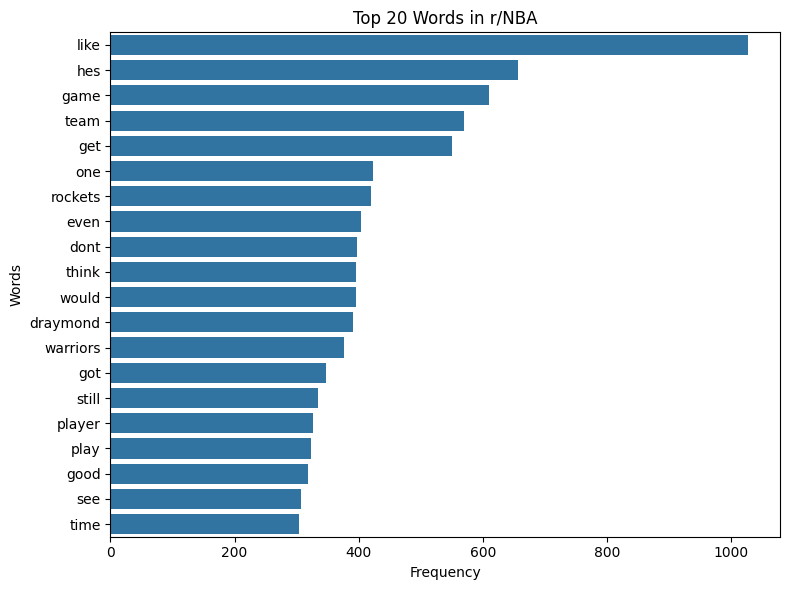

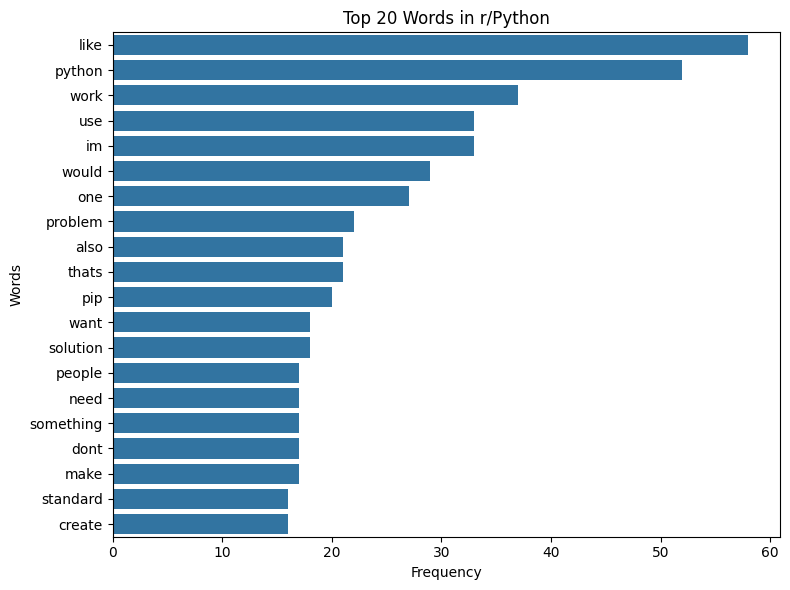

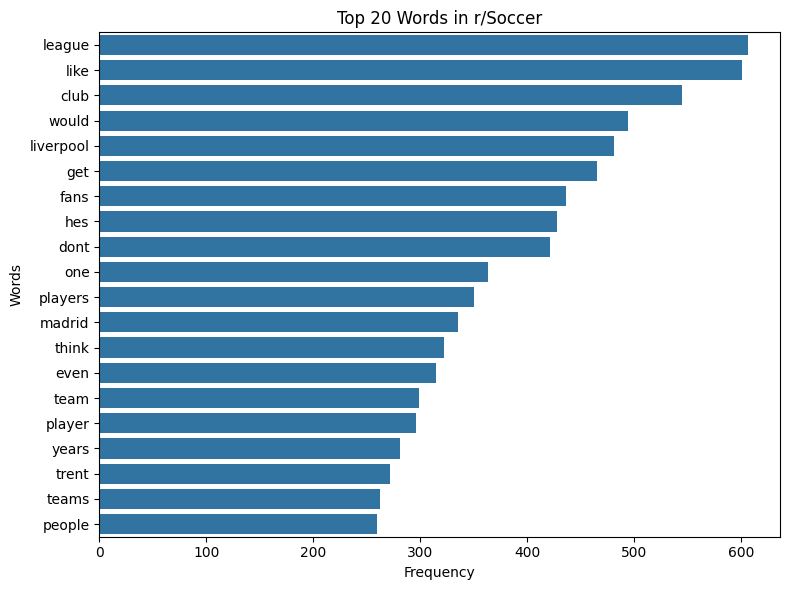

In [31]:
nba_top_words = analyze_word_frequency(cleaned_nba_comments)
nba_plot = plot_word_frequency(nba_top_words, "NBA")
plt.show()

python_top_words = analyze_word_frequency(cleaned_python_comments)
python_plot = plot_word_frequency(python_top_words, "Python")
plt.show()

soccer_top_words = analyze_word_frequency(cleaned_soccer_comments)
soccer_plot = plot_word_frequency(soccer_top_words, "Soccer")
plt.show()




Analyzed the polarity of each comment and post to see if its postive, negative or neutral

In [33]:
soccer_sentiment_results = analyze_sentiment(dataScience_subreddit)
soccer_sentiment_results



{'post_sentiment': {'compound': 0.14416,
  'positive': 0.0779,
  'negative': 0.07204999999999999,
  'neutral': 0.8500499999999999},
 'comment_sentiment': {'compound': 0.1686354798761613,
  'positive': 0.13917750257997935,
  'negative': 0.08097234262125913,
  'neutral': 0.7786144478844172}}

In [34]:
python_sentiment_results = analyze_sentiment(python_subreddit)
python_sentiment_results

{'post_sentiment': {'compound': 0.698025,
  'positive': 0.13165,
  'negative': 0.0225,
  'neutral': 0.8458},
 'comment_sentiment': {'compound': 0.2643834437086091,
  'positive': 0.13749668874172194,
  'negative': 0.03753973509933775,
  'neutral': 0.8249503311258278}}

In [35]:
nba_sentiment_results = analyze_sentiment(nba_subreddit)
nba_sentiment_results

{'post_sentiment': {'compound': 0.32363,
  'positive': 0.1213,
  'negative': 0.038599999999999995,
  'neutral': 0.83995},
 'comment_sentiment': {'compound': 0.09571410044500976,
  'positive': 0.1382565797838522,
  'negative': 0.10215702479338813,
  'neutral': 0.7592034329307028}}

Look at the top topics 

In [37]:
nba_topics = extract_topics(nba_subreddit)
nba_topics

[['steph',
  'rockets',
  'warriors',
  'curry',
  'houston',
  'lol',
  'draymond',
  'fans',
  'team',
  'fuck'],
 ['game',
  'green',
  'team',
  'series',
  'think',
  'jalen',
  'season',
  'get',
  'rockets',
  'like'],
 ['hes',
  'brooks',
  'like',
  'dont',
  'pop',
  'players',
  'people',
  'guy',
  'love',
  'shit'],
 ['like',
  'draymond',
  'get',
  'buddy',
  'hate',
  'warriors',
  'lol',
  'right',
  'man',
  'game'],
 ['im',
  'years',
  'like',
  'see',
  'year',
  'still',
  'time',
  'one',
  'team',
  'spurs']]

In [38]:
soccer_topics = extract_topics(dataScience_subreddit)
soccer_topics


[['league',
  'teams',
  'champions',
  'cl',
  'would',
  'get',
  'top',
  'europa',
  'cup',
  'win'],
 ['liverpool',
  'club',
  'fans',
  'hes',
  'madrid',
  'trent',
  'leaving',
  'player',
  'free',
  'dont'],
 ['like',
  'hes',
  'one',
  'game',
  'even',
  'football',
  'think',
  'thats',
  'team',
  'right'],
 ['players',
  'would',
  'dont',
  'contract',
  'like',
  'didnt',
  'think',
  'years',
  'video',
  'italy'],
 ['season',
  'last',
  'next',
  'back',
  'us',
  'years',
  'games',
  'team',
  'barcelona',
  'th']]

In [39]:
python_topics = extract_topics(python_subreddit)
python_topics




[['one',
  'like',
  'problem',
  'day',
  'im',
  'know',
  'rust',
  'solution',
  'lot',
  'think'],
 ['ive',
  'observability',
  'type',
  'solution',
  'celery',
  'better',
  'years',
  'search',
  'learning',
  'thats'],
 ['like',
  'python',
  'would',
  'use',
  'im',
  'want',
  'work',
  'file',
  'way',
  'standard'],
 ['asyncmq',
  'im',
  'job',
  'like',
  'also',
  'use',
  'python',
  'many',
  'doesnt',
  'hatched'],
 ['python',
  'uv',
  'using',
  'project',
  'work',
  'use',
  'install',
  'folder',
  'pdf',
  'new']]